<a href="https://colab.research.google.com/github/haewonChun/python_algorithms/blob/main/%5B%EB%AC%B8%EC%A0%9C%5DChapter_1_image_classficiation_%EB%AA%A8%EB%8D%B8_%EA%B5%AC%ED%98%84_%EB%B0%8F_%EC%84%B1%EB%8A%A5_%EA%B0%9C%EC%84%A0%ED%95%98%EA%B8%B0_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주제: CNN을 이용한 Image Classification 구현하고 성능 개선하기

## 실습 가이드
    1. 데이터를 다운로드하여 Colab에 불러옵니다.
    2. 필요한 라이브러리는 import 가능합니다.
    3. 코드는 위에서부터 아래로 순서대로 실행합니다.

## 데이터 소개
    - 이번 주제는 Intel image classification dataset을 사용합니다.
    - Intel image classification dataset은 buildings, forest, mountains, glacier, sea, street 6개의 class로 구성되어 있습니다.
    - 파일은 하나의 압축파일로 구성되며 압축파일은 다음과 같이 구성되어 있습니다.
    - 모든 데이터는 각 class 이름에 해당되는 directory 아래에 있습니다.    

    1. seg_train
      - training용 data
      
    2. seg_test
      - test/validation용 data
      - label 있음
      - 이번 실습에서는 validation data로 사용

    3. set_pred
      - test용 data
      - label 없음
      - 이번 실습에서는 사용하지 않음

- 원본 데이터 출처: https://www.kaggle.com/puneet6060/intel-image-classification

## 문제 소개
    - 이번 실습에서는 image classification model을 만들어서 학습하고, 성능을 향상하기 위한 방법들을 찾아서 학습해보도록 하겠습니다.

## 최종 목표    
    - pre-trained CNN 활용 방법 이해
    - CNN의 성능을 올리기 위한 다양한 방법 습득

- 출제자: 이진원 강사

## Step 1. 데이터 다운로드 및 전처리

In [ ]:
## library를 import 합니다
## 추가로 필요한 library가 있으면 추가로 import 해도 좋습니다
import os
import numpy as np
import random
from datetime import datetime
import time
import math
import gdown
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Softmax

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
import os
import numpy as np
import random
from datetime import datetime
import time
import math
import gdown
import matplotlib.pyplot as plit
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [ ]:
## Hyper-Parameter 설정
# image resolution
RES = 224
# class 수
N_CLASS = 6
# batch size
N_BATCH = 64
# epoch 수
N_EPOCH = 50
# learning rate
LR = 0.0001

### 문제 1. 데이터 불러오기

    - data는 아래 url(google drive)에 저장되어 있습니다.(tar 파일)
    - gdown library를 이용하여 data를 다운받고, 현재 directory에 tar파일 압축을 풀어줍니다.
    

In [ ]:
data_url = 'https://drive.google.com/uc?id=1bDyPlWP3AczXJbBmmjSGuAJXY7R_IjeJ'

In [ ]:
## data download 받기(gdown.download 사용)
##### CODE HERE #####
import gdown
gdown.download(data_url)



Downloading...
From: https://drive.google.com/uc?id=1bDyPlWP3AczXJbBmmjSGuAJXY7R_IjeJ
To: /content/intel_image_classification.tar
100%|██████████| 388M/388M [00:03<00:00, 99.3MB/s]


'intel_image_classification.tar'

In [ ]:
!tar -xvf intel_image_classification.tar

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
seg_pred/seg_pred/4180.jpg
seg_pred/seg_pred/4183.jpg
seg_pred/seg_pred/4185.jpg
seg_pred/seg_pred/4188.jpg
seg_pred/seg_pred/4190.jpg
seg_pred/seg_pred/4195.jpg
seg_pred/seg_pred/4196.jpg
seg_pred/seg_pred/4198.jpg
seg_pred/seg_pred/420.jpg
seg_pred/seg_pred/4200.jpg
seg_pred/seg_pred/4201.jpg
seg_pred/seg_pred/4203.jpg
seg_pred/seg_pred/4204.jpg
seg_pred/seg_pred/4206.jpg
seg_pred/seg_pred/4207.jpg
seg_pred/seg_pred/4212.jpg
seg_pred/seg_pred/4213.jpg
seg_pred/seg_pred/4214.jpg
seg_pred/seg_pred/4216.jpg
seg_pred/seg_pred/4219.jpg
seg_pred/seg_pred/4220.jpg
seg_pred/seg_pred/4222.jpg
seg_pred/seg_pred/4223.jpg
seg_pred/seg_pred/4226.jpg
seg_pred/seg_pred/4229.jpg
seg_pred/seg_pred/423.jpg
seg_pred/seg_pred/4236.jpg
seg_pred/seg_pred/4237.jpg
seg_pred/seg_pred/424.jpg
seg_pred/seg_pred/4240.jpg
seg_pred/seg_pred/4241.jpg
seg_pred/seg_pred/4242.jpg
seg_pred/seg_pred/4243.jpg
seg_pred/seg_pred/4245.jpg
seg_pred/seg_pred/4246.jpg
seg_pred/seg_pred/4247

    - 아래와 같이 train dataset은 train_dir, validation dataset은 val_dir로 경로를 설정합니다

In [ ]:
data_dir = "."
train_dir = os.path.join(data_dir, 'seg_train', 'seg_train')
val_dir = os.path.join(data_dir, 'seg_test', 'seg_test')

In [ ]:
!ls $train_dir

buildings  forest  glacier  mountain  sea  street


### 문제 2. dataset 만들기
    - keras.preprocessing.image_dataset_from_directory를 이용하여 training용 dataset(이름: train_ds), validation용 dataset(이름: val_ds)를 만듭니다.
    - 위 hyperparameter를 참조하여 image_size와 batch_size를 설정합니다.
    - training data는 shuffle=True로 설정합니다.

In [ ]:
##### CODE HERE #####
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((RES, RES)),
    transforms.ToTensor(),
])

train_ds = datasets.ImageFolder(train_dir, transform=transform)
train_loader =torch.utils.data.DataLoader(train_ds, batch_size=N_BATCH, shuffle=True)
val_ds = datasets.ImageFolder(val_dir, transform=transform)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=N_BATCH, shuffle=True)

### 문제 3. training data, validation data 갯수 확인
    - 위 dataset 생성시에 나오는 log에서 training data와 validation data의 갯수를 확인하여, 각각 N_TRAIN, N_VAL 변수에 저장합니다.

In [ ]:
train_ds, val_ds

(Dataset ImageFolder
     Number of datapoints: 14034
     Root location: ./seg_train/seg_train
     StandardTransform
 Transform: Compose(
                Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 3000
     Root location: ./seg_test/seg_test
     StandardTransform
 Transform: Compose(
                Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [ ]:
train_ds, val_ds

(Dataset ImageFolder
     Number of datapoints: 14034
     Root location: ./seg_train/seg_train
     StandardTransform
 Transform: Compose(
                Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 3000
     Root location: ./seg_test/seg_test
     StandardTransform
 Transform: Compose(
                Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [ ]:
train_loader, val_loader

(<torch.utils.data.dataloader.DataLoader at 0x7b4ac8d01720>,
 <torch.utils.data.dataloader.DataLoader at 0x7b4ab1f1dcf0>)

In [ ]:
##### CODE HERE #####
N_TRAIN = len(train_ds)
N_VAL = len(val_ds)
print(N_TRAIN, N_VAL)
NUM_CLASSES = len(train_ds.classes)
print(NUM_CLASSES)

14034 3000
6


### 문제 4. class list 만들기
    - class 이름을 저장하고 있는 list를 생성합니다

In [ ]:
##### CODE HERE #####
class_list = train_ds.classes
print(class_list)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


    - data 공급 속도를 빠르게 하기 위하여 dataset에 prefetch를 적용합니다

In [ ]:
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

AttributeError: 'ImageFolder' object has no attribute 'prefetch'

In [ ]:
import torch.utils.data.dataloader as dataloader
def my_collate_fn(batch):
    """Custom collate function that can handle batches with different-sized tensors."""
    # Get the data from the batch
    data = []
    for elem in batch:
        if isinstance(elem, torch.Tensor):
            data.append(F.interpolate(elem, size=(224, 224)))
        else:
            data.append(elem)
    return dataloader.default_collate(data)
num_workers = 2
train_loader = DataLoader(train_ds, batch_size=N_BATCH, shuffle=True, collate_fn=my_collate_fn, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=N_BATCH, shuffle=True, collate_fn=my_collate_fn, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### 문제 5. dataset 확인하기
    - train_ds에서 batch를 5개 읽어와서 각 batch의 첫번째 image를 화면에 출력합니다.
    - 위 class list에서 image에 대한 label을 찾아서 title로 넣습니다.

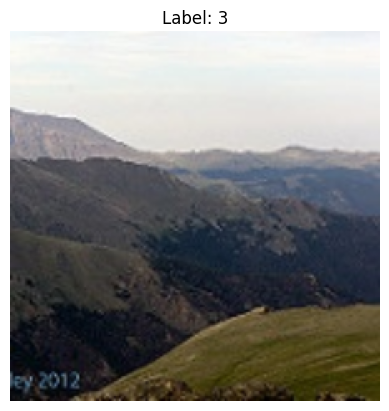

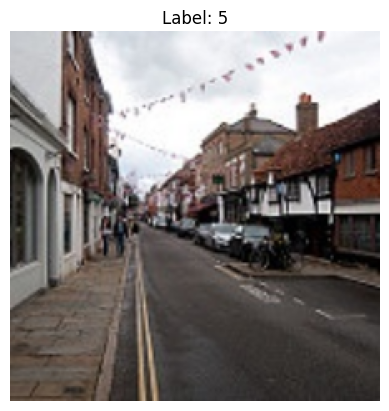

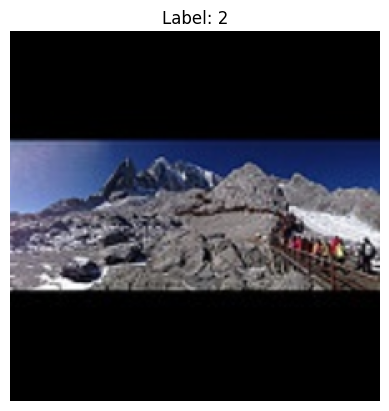

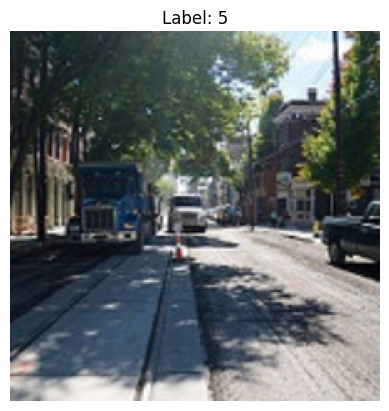

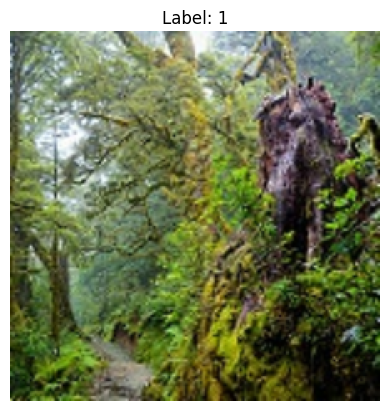

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# 가정: train_ds는 사용자가 정의한 데이터셋이라고 가정
# DataLoader를 사용하여 데이터를 읽어옴

# Iterate through batches and display the first images
for batch_id, (data, labels) in enumerate(train_loader):
    first_image = data[0].permute(1,2,0).numpy()  # Extract the first image from the batch
    label = labels[0]  # Extract label for the current image

    # Display the image
    plt.imshow(first_image)
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

    if batch_id == 4:  # Display images from the first 5 batches
        break

## Step 2. Pretrained MobileNetV3로 Training 하기
이번 Step에서는 MobileNetV3를 이용하여 image classification을 학습해보겠습니다.

    - pretrained MobileNetV3는 tensorflow.keras.applications에서 기본으로 제공합니다.
    - 아래와 같이 pretrained MobileNetV3 model을 다운받습니다.
  

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
mobilenetv3 = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(RES, RES, 3))

In [ ]:
import torchvision.models as models

mobileNetV3 = models.mobilenet_v3_small(pretrained = True, include_top=False, input_shape=(RES, RES, 3))



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
mobilenetv3.summary()

In [ ]:
!pip install torchinfo

In [ ]:
import torch
import torchvision.models as models
from torchinfo import summary

# MobileNetV3 다운로드
mobileNetV3 = models.mobilenet_v3_small(pretrained=True)

# GPU가 사용 가능한지 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델을 GPU로 이동
mobileNetV3.to(device)

# 모델 요약 출력
summary(mobileNetV3, input_size=(1, 3, 224, 224), device=device)

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [1, 1000]                 --
├─Sequential: 1-1                                  [1, 576, 7, 7]            --
│    └─Conv2dNormActivation: 2-1                   [1, 16, 112, 112]         --
│    │    └─Conv2d: 3-1                            [1, 16, 112, 112]         432
│    │    └─BatchNorm2d: 3-2                       [1, 16, 112, 112]         32
│    │    └─Hardswish: 3-3                         [1, 16, 112, 112]         --
│    └─InvertedResidual: 2-2                       [1, 16, 56, 56]           --
│    │    └─Sequential: 3-4                        [1, 16, 56, 56]           744
│    └─InvertedResidual: 2-3                       [1, 24, 28, 28]           --
│    │    └─Sequential: 3-5                        [1, 24, 28, 28]           3,864
│    └─InvertedResidual: 2-4                       [1, 24, 28, 28]           --
│    │    └─Sequential: 3-6   

### 문제 6. Intel image classification을 위한 MobileNetV3 model 만들기    
    - functional API를 활용하여 6개의 class를 classification하는 model을 만들어봅시다.
    - fully connected layer는 1개만 추가하고, batchnorm을 사용합니다.
    - MobileNetV3에 data가 들어가기 전에 preprocess_input을 적용하여 input data가 preprocessing될 수 있도록 합니다.

In [ ]:
##### CODE HERE ####
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models

class ModifiedMobileNetV3(nn.Module):
    def __init__(self, num_classes=6):
        super(ModifiedMobileNetV3, self).__init__()

        # Load the MobileNetV3 small model without the classifier
        mobilenet_v3 = models.mobilenet_v3_small(pretrained=True)
        self.features = mobilenet_v3.features

        # Add a fully connected layer with batch normalization
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(576, 256),  # Output size can be adjusted
            nn.BatchNorm1d(256),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes),  # The number of output classes
        )

    def forward(self, x):
        ## Apply preprocess_input function
        #x = preprocess_input(x)

        # Apply feature extraction
        x = self.features(x)

        # Apply the fully connected layer
        x = self.fc(x)

        return x

# Create an instance of the modified model
model = ModifiedMobileNetV3(num_classes=6)

# 모델 요약 출력
summary(model, input_size=(1, 3, 224, 224), device=device)


Layer (type:depth-idx)                             Output Shape              Param #
ModifiedMobileNetV3                                [1, 6]                    --
├─Sequential: 1-1                                  [1, 576, 7, 7]            --
│    └─Conv2dNormActivation: 2-1                   [1, 16, 112, 112]         --
│    │    └─Conv2d: 3-1                            [1, 16, 112, 112]         432
│    │    └─BatchNorm2d: 3-2                       [1, 16, 112, 112]         32
│    │    └─Hardswish: 3-3                         [1, 16, 112, 112]         --
│    └─InvertedResidual: 2-2                       [1, 16, 56, 56]           --
│    │    └─Sequential: 3-4                        [1, 16, 56, 56]           744
│    └─InvertedResidual: 2-3                       [1, 24, 28, 28]           --
│    │    └─Sequential: 3-5                        [1, 24, 28, 28]           3,864
│    └─InvertedResidual: 2-4                       [1, 24, 28, 28]           --
│    │    └─Sequential: 3-6   

  ### 문제 7. 학습하기
    - SGD를 사용하여 model을 학습합니다.(총 epoch수는 N_EPOCH으로 설정)
    - learning rate은 위에서 정한 hyperparameter(LR)을 사용합니다.
    - loss는 cross entropy를 사용합니다.

In [ ]:
##### CODE HERE #####

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary
from PIL import Image
import torchvision.models as models

# Check if GPU is available and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print model summary
summary(model, input_size=(1, 3, 224, 224), device=device)

# Define optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
criterion = nn.CrossEntropyLoss()

for epoch in range(N_EPOCH):
    model.train()  # Set the model to training mode

    for batch_id, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(data)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        if batch_id % 100 == 0:
            print(f'Epoch [{epoch + 1}/{N_EPOCH}], Step [{batch_id + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print("Training finished.")

Epoch [1/50], Step [1/220], Loss: 2.0036


KeyboardInterrupt: 

### 문제 8. Optimizer 변경하기
    - 같은 model에서 optimizer만 Adam으로 변경하여 학습해봅시다.

In [ ]:
##### CODE HERE #####
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary
from PIL import Image
import torchvision.models as models

# Check if GPU is available and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print model summary
summary(model, input_size=(1, 3, 224, 224), device=device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

for epoch in range(N_EPOCH):
    model.train()  # Set the model to training mode

    for batch_id, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), torch.tensor(labels).to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(data)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        if batch_id % 100 == 0:
            print(f'Epoch [{epoch + 1}/{N_EPOCH}], Step [{batch_id + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print("Training finished.")

<ipython-input-64-59faa76871b9>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, labels = data.to(device), torch.tensor(labels).to(device)


Epoch [1/50], Step [1/220], Loss: 1.5832
Epoch [1/50], Step [101/220], Loss: 0.2970
Epoch [1/50], Step [201/220], Loss: 0.2439
Epoch [2/50], Step [1/220], Loss: 0.2449
Epoch [2/50], Step [101/220], Loss: 0.2739
Epoch [2/50], Step [201/220], Loss: 0.2108
Epoch [3/50], Step [1/220], Loss: 0.1002
Epoch [3/50], Step [101/220], Loss: 0.1331
Epoch [3/50], Step [201/220], Loss: 0.1784
Epoch [4/50], Step [1/220], Loss: 0.1411
Epoch [4/50], Step [101/220], Loss: 0.0780
Epoch [4/50], Step [201/220], Loss: 0.1398
Epoch [5/50], Step [1/220], Loss: 0.0896
Epoch [5/50], Step [101/220], Loss: 0.0677
Epoch [5/50], Step [201/220], Loss: 0.1156
Epoch [6/50], Step [1/220], Loss: 0.0201
Epoch [6/50], Step [101/220], Loss: 0.0762
Epoch [6/50], Step [201/220], Loss: 0.0748
Epoch [7/50], Step [1/220], Loss: 0.0643
Epoch [7/50], Step [101/220], Loss: 0.0613
Epoch [7/50], Step [201/220], Loss: 0.0460
Epoch [8/50], Step [1/220], Loss: 0.0397
Epoch [8/50], Step [101/220], Loss: 0.0839
Epoch [8/50], Step [201/220

## Step3. Model 성능 올리기

이번 Step에서는 다양한 방법을 사용하여 MobileNetV3의 성능을 올려보도록 하겠습니다.

### 문제 9. Data augmentation 사용하기
    - training data에 data augmentation을 적용해봅시다.
    - dataset을 만들 때 training data를 256x256으로 resize합니다.
    - augmentation function을 만들고, 224x224로 random crop합니다.
    - horizontal flip도 random으로 적용합니다.
    - augmentation을 하였으므로 training epoch을 100으로 키웁니다.
    - optimizer와 다른 hyperparameter는 수정하지 않고 training합니다.

In [ ]:
##### CODE HERE ####
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary
from PIL import Image
import torchvision.models as models

# 데이터 증강 함수 정의
def data_augmentation(image):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(image)

# 훈련 데이터셋과 DataLoader 정의
train_transform = transforms.Compose([
    data_augmentation,  # 데이터 증강 함수 적용
])


train_ds = datasets.ImageFolder(train_dir, transform=train_transform)
train_loader =torch.utils.data.DataLoader(train_ds, batch_size=N_BATCH, shuffle=True)
val_ds = datasets.ImageFolder(val_dir, transform=train_transform)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=N_BATCH, shuffle=True)


# 모델, 최적화기, 손실 함수 정의
model = ModifiedMobileNetV3(num_classes=10)  # Assuming 10 classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

# 학습 루프
num_epochs = 100

for epoch in range(num_epochs):
    model.train()  # 훈련 모드로 설정

    for batch_id, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), torch.tensor(labels).to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if batch_id % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{batch_id + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print("Training finished.")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-66-b1c841b9e340>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, labels = data.to(device), torch.tensor(labels).to(device)


Epoch [1/100], Step [1/220], Loss: 2.3714
Epoch [1/100], Step [101/220], Loss: 0.5065
Epoch [1/100], Step [201/220], Loss: 0.3004
Epoch [2/100], Step [1/220], Loss: 0.4516
Epoch [2/100], Step [101/220], Loss: 0.1848
Epoch [2/100], Step [201/220], Loss: 0.1790
Epoch [3/100], Step [1/220], Loss: 0.2373
Epoch [3/100], Step [101/220], Loss: 0.0784
Epoch [3/100], Step [201/220], Loss: 0.2416
Epoch [4/100], Step [1/220], Loss: 0.1168
Epoch [4/100], Step [101/220], Loss: 0.2130
Epoch [4/100], Step [201/220], Loss: 0.1564
Epoch [5/100], Step [1/220], Loss: 0.2109
Epoch [5/100], Step [101/220], Loss: 0.1162
Epoch [5/100], Step [201/220], Loss: 0.1698
Epoch [6/100], Step [1/220], Loss: 0.2765
Epoch [6/100], Step [101/220], Loss: 0.1247
Epoch [6/100], Step [201/220], Loss: 0.0945
Epoch [7/100], Step [1/220], Loss: 0.0439
Epoch [7/100], Step [101/220], Loss: 0.0987
Epoch [7/100], Step [201/220], Loss: 0.1151
Epoch [8/100], Step [1/220], Loss: 0.0866
Epoch [8/100], Step [101/220], Loss: 0.0854
Epoc

### 문제 10. cutmix 알고리즘 구현을 위한 dataset 재생성
    - data augmentation 방법 중 하나인 cutmix를 구현해봅시다.
    - 논문은 https://arxiv.org/abs/1905.04899 에서 확인할 수 있습니다.
    - 알고리즘에 대한 간략한 설명은 맨 첫부분에 이론강의로 제공되니, 강의를 시청하고 문제를 푸는 것도 좋습니다.

    - cutmix를 위해서는 사전에 label이 one-hot encoding되어 있어야 하므로, dataset을 수정하여 label이 one-hot이 되도록 합니다.

In [ ]:
##### CODE HERE #####

    - 아래 코드를 실행하여 제대로 one-hot encoding이 되어있는지 확인해봅시다

In [ ]:
for images, labels in train_ds.take(1):
  print(labels[0].numpy())
for images, labels in val_ds.take(1):
  print(labels[0].numpy())

### 문제 11. cutmix 알고리즘 구현
    - cutmix 알고리즘을 구현해봅시다.
    - cutmix라는 함수를 만들어서 구현합니다.
    - 위에서 생성한 dataset에 map으로 적용할 수 있도록 images, labels를 입력으로 받습니다.

In [ ]:
##### CODE HERE #####

### 문제 12. cutmix 적용 및 확인
    - 작성한 cutmix 알고리즘을 train_ds에 적용하고, 문제 5에서와 같이 확인해봅니다.
    - 앞에서 적용했던 random crop과 random flip도 함께 적용합니다.

In [ ]:
##### CODE HERE #####

### 문제 13. cutmix 적용하여 training
    - model을 새로 생성하고 학습하여 결과를 확인해봅시다.
    - 다른 hyperparameter는 이전과 동일하게 하여 결과를 비교해봅시다.

In [ ]:
##### CODE HERE #####

### 문제 14. Bigger resolution
    - input image resolution을 320x320으로 키워봅시다.
    - random crop을 적용하기 전 resolution은 330x330으로 설정합니다.
    - resolution에 맞게 train_ds와 val_ds를 다시 생성하고, data augmentation을 동일하게 적용합니다.

  

In [ ]:
##### CODE HERE #####

### 문제 15. Learning rate warmup + cosine decay 구현하기
    - custom learning rate scheduler를 만들어서 warm up과 cosine anealing을 구현해봅시다.
    - max_lr, warmup_steps, decay_steps 세가지 항목을 입력을 받을 수 있도록 합니다.
    - max_lr은 최대 learning rate, warmup_steps는 warm up이 끝나는 step 수, decay steps는 cosine decay가 끝나는 step 수를 의미합니다.
    - keras.optimizers.schedules.LearningRateSchedule를 상속하여 subclass로 만듭니다.
    - 자세한 사항은 아래 링크들을 참고하시면 됩니다.
https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/LearningRateSchedule

https://www.tensorflow.org/tutorials/text/transformer

In [ ]:
##### CODE HERE #####
import math
import torch
from torch.optim.lr_scheduler import _LRScheduler

class CustomLRScheduler(_LRScheduler):
    def __init__(self, optimizer, max_lr, warmup_steps, decay_steps, last_epoch=-1):
        self.max_lr = max_lr
        self.warmup_steps = warmup_steps
        self.decay_steps = decay_steps
        super(CustomLRScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup_steps:
            # Warm-up phase: Linearly increase learning rate from 0 to max_lr
            return [self.last_epoch / self.warmup_steps * self.max_lr for _ in self.optimizer.param_groups]
        else:
            # Cosine annealing phase: Use cosine annealing with decay_steps
            cosine_decay = 0.5 * (1 + math.cos((self.last_epoch - self.warmup_steps) / self.decay_steps * math.pi))
            return [cosine_decay * self.max_lr for _ in self.optimizer.param_groups]

# 예제 사용법
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
max_lr = 0.1
warmup_steps = 500
decay_steps = 5000
scheduler = CustomLRScheduler(optimizer, max_lr, warmup_steps, decay_steps)

# 학습 루프에서 매 에폭마다 스케줄러 업데이트
for epoch in range(num_epochs):
    train(...)
    scheduler.step()


### 문제 16. Learning rate scheduling visualization
    - 위에서 작성한 learning rate scheduling class가 제대로 동작하는지 적당한 값을 넣고 graph를 그려서 확인해봅시다.

In [ ]:
##### CODE HERE #####

### 문제 17. Label smoothing 적용하여 학습하기
    - 위에서 새로 적용한 모든 것들(resolution, epoch 수, learning rate scheduling)을 다 반영하고, label smoothing까지 적용하여 학습해봅시다.
    - max_lr은 LR로, warmup_steps는 3 epoch에 해당하는 step수, decay_steps는 N_EPOCH에 해당하는 step수만큼으로 설정합니다.
    - label smoothing 값은 0.1로 설정합니다.

In [ ]:
##### CODE HERE #####
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.optim import SGD
from torch.optim.lr_scheduler import MultiStepLR
from custom_lr_scheduler import CustomLRScheduler

# Custom Learning Rate Scheduler
max_lr = 0.01  # 최대 Learning Rate
warmup_steps = 3 * len(train_loader)  # 3 에폭에 해당하는 step 수
decay_steps = N_EPOCHS * len(train_loader)  # N 에폭에 해당하는 step 수
scheduler = CustomLRScheduler(optimizer, max_lr, warmup_steps, decay_steps)

# Label Smoothing Loss
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1, classes=1000):
        super(LabelSmoothingLoss, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='batchmean')
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.classes = classes

    def forward(self, x, target):
        # x: log_softmax 확률 분포, target: 정답 레이블
        assert x.size(1) == self.classes
        true_dist = torch.zeros_like(x)
        true_dist.fill_(self.smoothing / (self.classes - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return self.criterion(x, true_dist)

criterion = LabelSmoothingLoss(smoothing=0.1, classes=num_classes)

# 모델 정의 (ResNet-18)
model = models.resnet18(pretrained=False, num_classes=num_classes)

# 학습 루프
for epoch in range(N_EPOCHS):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()  # Learning Rate 스케줄링 적용


### 문제 18. Learning rate decay(계단식) 적용하여 학습하기
    - 계단식으로 learning rate decay를 적용해봅시다.
    - 매 30 epoch마다 1/10로 learning rate을 decay 시키도록 하여 학습해봅시다.
    - 구현은 keras.optimizers.schedules.ExponentialDecay API를 활용합니다.
https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay

In [ ]:
##### CODE HERE #####
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR

# 데이터 로드 및 전처리
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 모델 정의 (ResNet-18)
model = models.resnet18(pretrained=False, num_classes=10)

# Optimizer 및 Learning Rate Scheduler 설정
optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)  # 30 epoch마다 1/10로 감소

# 학습 루프
num_epochs = 100  # 예제에서는 100 epoch까지 수행하겠습니다.
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    scheduler.step()  # Learning Rate 감소 적용

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], LR: {scheduler.get_lr()[0]:.6f}, Loss: {loss.item():.4f}')

# 학습 종료 후 모델 저장 등 추가 작업을 수행할 수 있습니다.
